In [1]:
import numpy as np
import pandas as pd
import astropy.io.fits as apfits
import astropy.visualization as apvis
import astropy.nddata as apnndd
import astropy.table as aptable
import astropy.wcs as apwcs
import astropy.units as apunits
import astropy.coordinates as apcoords
import pandas as pd
import matplotlib.pyplot as mplplot
import matplotlib.patches as mplpatches
import glob
import os
import scipy as sp
import scipy.optimize as spopt
import copy

import grismconf

In [2]:
!pwd

/Users/zx446701/Documents/Astro_Projects/IceAge_ERS/Spectral_Extraction_Code


### Accessing Fengwu Data Files (Ex HD)

In [3]:
frameFitsDir = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_frames" 
frameListDir = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_list"
frameSpec2dDir = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/extract_2d/"

#### Arrange the frames fits file list into the required format

In [4]:
# Create full list of files within folder as a list
frameFitsFiles = glob.glob(os.path.join(frameFitsDir, "*.fits")) 
# Format frameFitsFiles into a dictionary

frameFitsFiles = {
    idx: np.sort(data.to_numpy().flatten())
    for idx, data in pd.DataFrame(frameFitsFiles).groupby(
        by=pd.DataFrame(frameFitsFiles)
        .loc[:, 0]
        .apply(lambda x: "_".join(os.path.basename(x).split("_")[:3]))
    )
}

#### Define functions to extract the source list, along with sky and pixel coordinates within the images

In [5]:
# Define function to extract the source list of sources within an uncalibrated image
def getSourceListForImage(image, frameListDir):
    listPath = os.path.join(
        frameListDir,
        f"{'_'.join(os.path.basename(image).split('_')[:4])}_uncal_pointsources.list",
    )
    return pd.read_csv(listPath, delim_whitespace=True, comment="#", header=None)

In [6]:
# Define function to extract the source sky coordinates of sources within an uncalibrated image
def getSourceCoordsForImage(image, frameListDir):
    sourceList = getSourceListForImage(image, frameListDir) # Use previous function within this one
    coords = apcoords.SkyCoord(
        *sourceList.loc[:, [3, 4]].to_numpy().T, frame=apcoords.ICRS, unit=apunits.deg
    )
    return coords

In [7]:
# Define function to extract the source pixel coordinates of sources within an uncalibrated image
def getSourcePixelsForImage(image, frameListDir):
    sourceList = getSourceListForImage(image, frameListDir)
    pixels = sourceList.loc[:, [5, 6]].to_numpy()
    # pixels are the 
    return pixels

### Define Function to calculate the expected trace within the image

Code taken from https://github.com/npirzkal/GRISMCONF 

In [8]:
def computeTrace(pixels, fac=100, module="A", direction="R", simYDisp=False):
    # Locate config File for the module and grism direction 
    confFile = f"GRISM_NIRCAM/V2/NIRCAM_F322W2_mod{module}_{direction}.conf"
    # Class to read and hold GRISM configuration info
    conf = grismconf.Config(confFile)
    # Found from GRISMCONF README file - see link above
    # Middle section - number of pixels from end to start in X direction
    # 1/ middle = slighting trace by number of pixels
    # /fac is for splitting by subpixel amounts
    dt = np.abs(1 / (1 + conf.DISPX("+1", *pixels, 1) - conf.DISPX("+1", *pixels, 0)) / fac)
    t = np.arange(0, 1, dt)

    # DISP(X,Y,L) = DISPERSION POLYNOMIAL (X direction, Y, Full Length)
    # order, x0, y0, steps along dispersion between 0 and 1
    # X disp polynomial
    dxs = conf.DISPX("+1", *pixels, t)
    # Y disp polynomial 
    dys = conf.DISPY("+1", *pixels, t)
    # Compute wavelength of each pixel
    wavs = conf.DISPL("+1", *pixels, t)

    return (
        pixels[0] + dxs,
        pixels[1] + dys if simYDisp else np.full_like(dys, pixels[1]),
        wavs,
    )

DO WE NEED TO ADJUST THE RETURN PER DISPERSION DIRECTION??? R AND C USING DIFFERENT DXS AND DYS?

In [9]:
def computeTraceBox(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change module depending on module used for observation
    module="A",
    # Change Direction depending on disperser used for observation
    direction="R",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    height=50,
    # Need some guidance on what this is !
    **patchkws,
):
    confFile = f"GRISM_NIRCAM/V2/NIRCAM_F322W2_mod{module}_{direction}.conf"
    conf = grismconf.Config(confFile)
    # X and Y disp polynomials with 2 steps, the start and end of the trace
    dxs = conf.DISPX("+1", *pixels, np.array([0, 1]))
    # Is the Y needed for this?
    dys = conf.DISPY("+1", *pixels, np.array([0, 1]))
    
    #Locating the centre of the trace 
    centrePix = conf.DISPX("+1", *pixels, np.array([0.5]))

    if returnRect:
        mplplot.scatter(pixels[0]+centrePix[0], pixels[1],c='green')
        return mplpatches.Rectangle(
            # x0,y0 in bottom left of rectangle
            (pixels[0] + dxs[0], pixels[1] - height // 2),
            # width of rectangle 
            dxs[1] - dxs[0],
            # height of box (PSF width 50 pixels)
            height,
            **patchkws,
        )
    return (pixels[0]+centrePix[0], pixels[1]), (height, abs(dxs[1] - dxs[0]))

### Set up required variables for code
Retrieve each sources direct pixel and sky coordinates and create a Pandas dataframe of the direct pixel coords for manipulation later.

In [10]:
# Get sources from all images loaded into notebook
for imageFits in next(iter(frameFitsFiles.values())):
    directPixels = getSourcePixelsForImage(imageFits, frameListDir)
    DPdf = pd.DataFrame(directPixels)
    sourceCoords = getSourceCoordsForImage(imageFits, frameListDir)

### Create dataframe of x pixels at which each sources trace begins and ends

In [11]:
x = []
# y = []
# print(directPixels)
for directPixel in directPixels:
    confFile = f"GRISM_NIRCAM/V2/NIRCAM_F322W2_modB_R.conf"
    conf = grismconf.Config(confFile)
    # X and Y disp polynomials with 2 steps, the start and end of the trace
#     dxs = conf.DISPX("+1", *directPixel, np.array([0, 1]))
    x.append(directPixel[0] + conf.DISPX("+1", *directPixel, np.array([0, 1])))
    # Is the Y needed for this?
#     dys = conf.DISPY("+1", *directPixel, np.array([0, 1]))
#     dys.append(int(directPixel[1] + conf.DISPY("+1", *directPixel, np.array([0, 1]))))

dfx = pd.DataFrame(x)
# Rename the columns for pixel trace start and endpoints
dfx = dfx.rename(columns = {0 : "low_WL", 1 : "high_WL"})
# The X and Y pixels coordinates of the sources
dfx["Direct_X"] = DPdf[0]
dfx["Direct_Y"] = DPdf[1]
# The Sky Coordinates of sources
dfx["RA"] = sourceCoords.ra
dfx["Dec"] = sourceCoords.dec

# Dataframe sorted by trace starting furthest to the left
dfx = dfx.sort_values(by="low_WL")
# True or false to come next
dfx

,low_WL,high_WL,Direct_X,Direct_Y,RA,Dec
2,1190.617653,-552.410235,-350.219,2761.050,166.538658,-77.368153
62,1249.267653,-493.760235,-291.569,2214.600,166.534479,-77.377783
77,1253.754653,-489.273235,-287.082,738.874,166.535792,-77.403772
27,1374.203653,-368.824235,-166.633,2821.111,166.523950,-77.367183
33,1422.069653,-320.958235,-118.767,3081.354,166.519946,-77.362617
...,...,...,...,...,...,...
60,3937.981653,2194.953765,2397.145,1928.402,166.321112,-77.382772
78,3974.255653,2231.227765,2433.419,2151.594,166.318425,-77.378878
24,4022.226653,2279.198765,2481.390,642.758,166.312492,-77.405208
35,4044.791653,2301.763765,2503.955,2744.142,166.313175,-77.368531


### Plot Check of the uploaded files 

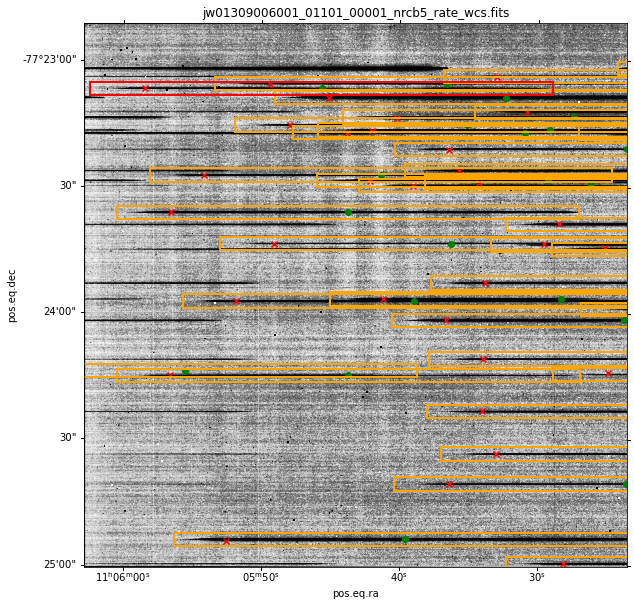

In [12]:
with apfits.open(imageFits) as test:
    figure = mplplot.figure(figsize=(10, 10))
    ax = figure.add_subplot(1, 1, 1, projection=apwcs.WCS(test["SCI"].header))    
    ax.imshow(
        # SCI is the images from the simulation
        test["SCI"].data,
        norm=apvis.ImageNormalize(
            stretch=apvis.HistEqStretch(data=test["SCI"].data),
            interval=apvis.ZScaleInterval(),
        ),
        cmap="Greys",
    )
        
    # Set image limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
#     sourceCoords = getSourceCoordsForImage(imageFits, frameListDir)
        
         # Plot sources on FOV
    ax.scatter(
        sourceCoords.ra,
        sourceCoords.dec,
        marker="x",
        c="r",
        transform=ax.get_transform("world"),
    )
    ax.set_title(os.path.basename(imageFits))
        
#     directPixels = getSourcePixelsForImage(imageFits, frameListDir)
#     print(imageFits, directPixels[24],directPixels[77] if len(directPixels) > 50 else "Short")
        
    # for loop to create trace boxes for each source within source list
    # HOW DO WE CHANGE FOR C DIRECTION?? NEED TO LOAD C DATA???
    # where is sourceId defined? Within imageFits???
    for sourceId, directPixel in enumerate(directPixels):
        traceBox = computeTraceBox(
            directPixel,
            module=os.path.basename(imageFits).split("_")[3][-2].upper(),
            direction="R",
            ec="red" if sourceId == 55 else "orange",
            #ec="orange",
            lw="2",
            fc="none",
        )
        ax.add_patch(traceBox)
        # Removing limits shows that all sources in list have traces calculated for them
        # Therefore missing traces must be due to them missing in source list which
        # will not be a problem once NIRCam Pre-imaging has been achieved
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

### Import PSF model grid modules

In [13]:
# Use source code to look into utils etc. - Ask Hugh how he knows when to look for these libraries!
from webbpsf.utils import to_griddedpsfmodel
from webbpsf.gridded_library import display_psf_grid
# How do we justify the model number (1-5??)
# Take specific instrument, module, filter and detector PSF fits files 
# and turn into a grid of how the PSF changes with position on detector array
# NUMBER OF DETECTOR IS IN NRCA5 - 5 IS LW DETECTOR 1-4 IS SW
# ONLY 5 REQUIRED FOR WFSS AS ONLY DETECTOR ABLE TO DO THIS
grid = to_griddedpsfmodel(
    "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/gridded_psf_library/nircam_nrca5_f322w2_clear_fovp47_samp5_npsf16_requirements_realization0.fits"
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-034 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-036
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


### Plot check of data within images 
In "data", the rows are the outside of the 2d array and columns on the inside - see .data[:,100] 

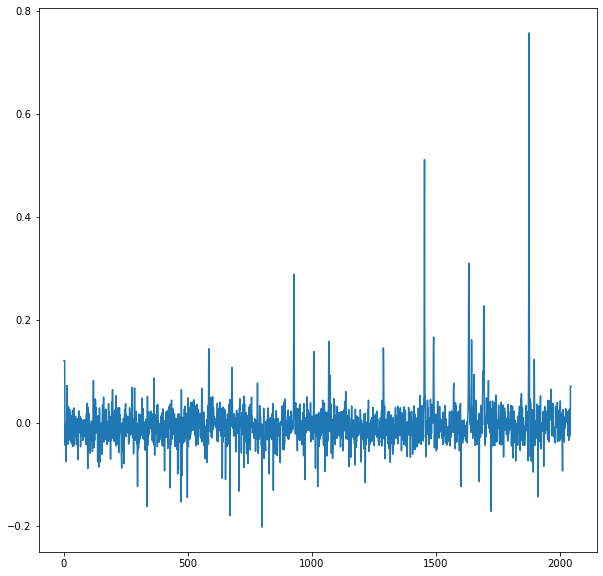

In [14]:
with apfits.open(imageFits) as test:
    data = test["SCI"].data
    figure = mplplot.figure(figsize=(10, 10))
    ax = figure.add_subplot(1, 1, 1, )#projection=apwcs.WCS(test["SCI"].header))    
#     ax.imshow(
#         # SCI is the images from the simulation
#         test["SCI"].data[:,100:101],
#         norm=apvis.ImageNormalize(
#             stretch=apvis.HistEqStretch(data=test["SCI"].data[:,100:101]),
#             interval=apvis.ZScaleInterval(),
#         ),
#         cmap="Greys",
#     )
    ax.plot(
    test["SCI"].data[:,100])

### Chi Squared fit function defined to find best fit parameters (Flux only at the moment)

In [141]:
# Chi squared function to test parameters fit
def fitFunction(norms, cutoutSlice, errorSlice, psfs, means, plotme=False):
#     figure = mplplot.figure(figsize = (15,15))
#     mplplot.plot(cutoutSlice, label='Cut')
#     mplplot.plot(errorSlice, label="err")
    # Error Mask to simulate likely errors when checking for what was causing incorrect fits
#     error_mask = np.ones_like(cutoutSlice)*1000
    selection = errorSlice > 0
    model = np.zeros_like(cutoutSlice)
    
    for norm, psf, mean in zip(norms, psfs, means):
        # May be better interpolated below
#         print(mean)
#         print(psf.size // 2)
#         print(model[max(0, int(mean) - psf.size // 2) : min(cutoutSlice.size, int(mean) + psf.size // 2)].size)
#         error_mask[int(mean) - psf.size // 2 : int(mean) + psf.size // 2] = 0.1
        model[int(mean) - psf.size // 2 : int(mean) + psf.size // 2] += norm * psf
    
    if plotme:
        fig, ((ax1),(ax2)) = mplplot.subplots(figsize=(10,20),nrows = 2, ncols =1)
        ax1.plot(cutoutSlice, label="Data")
        ax1.plot(model,label="Initial Model")
        ax1.legend()
        ax2.plot(errorSlice)
    return np.nansum(
        ((model[selection] - cutoutSlice[selection]) / errorSlice[selection]) ** 2
    )


"""
Single cutout could use a defined PSF function but this is now within the code in the cell below
"""

# def simplePsfMethod(cutout, error, psfs, xDispRange, ):
#     return[
#         spopt.minimize(
#             # parameters for function as a list in square brackets - part that varies
#             # if fitting multiple sources within box, need parameters per source
#             # This is the 'norm' within fitFunction
#             fitFunction,
#             [],
#             # Arguments - the constants 
#             (cutoutSlice[xDispRange], errorSlice[xDispRange], psfs[xDispRange]),
#         ).x[0]
#         for cutoutSlice, errorSlice in zip(cutout.T, error.T)
#     ]



'\nSingle cutout could use a defined PSF function but this is now within the code in the cell below\n'

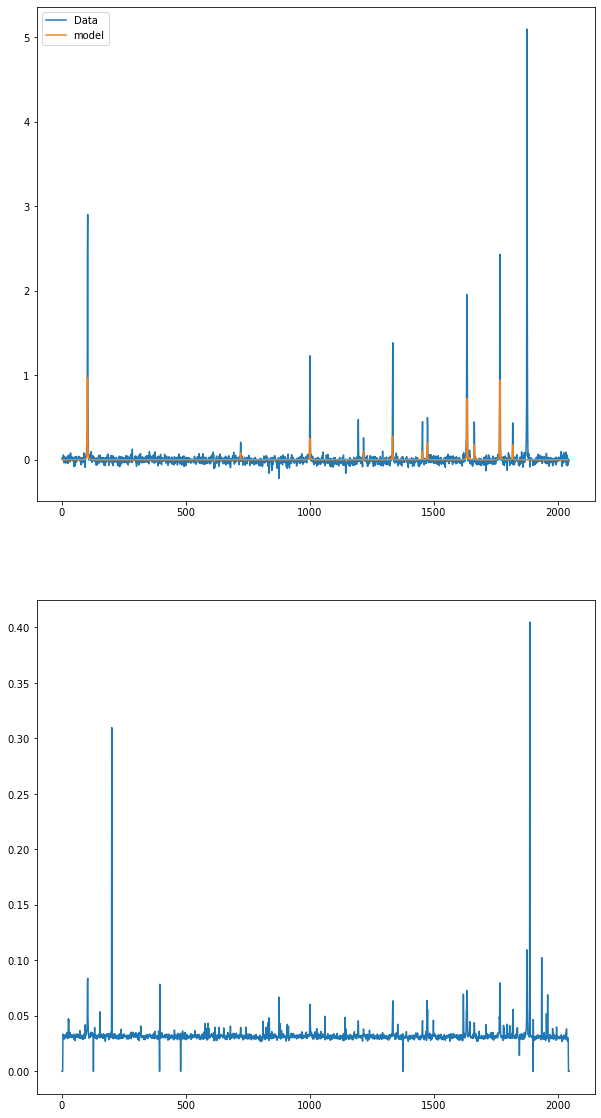

In [142]:
with apfits.open(imageFits) as test:
    
    # Created array for results
    result = np.zeros(shape=(dfx.shape[0],test["SCI"].data.T.shape[0]))
    grid = to_griddedpsfmodel(
    "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/gridded_psf_library/nircam_nrca5_f322w2_clear_fovp47_samp5_npsf16_requirements_realization0.fits"
    )
    # Take out data per column from the image
    
    fit_results = []
    all_columns_initial_params = []
    
    for column_number, (column, err_col) in enumerate(zip(test["SCI"].data.T, test["ERR"].data.T)):

        # Step 1: Work out which and how many traces there are in column to define params
        # Want all traces with a start < 0
        # How many traces are with sensitive pixels overlap the column as a boolean list
        # NASTY 30 PIXEL HACK TO STOP CRASHING - CANNOT FIT PSF FULLY TO TRACES THAT ARE 25 PIXELS FROM EDGE 
        mask = (dfx.high_WL <= column_number) & (dfx.low_WL >= column_number) & (dfx.Direct_Y >= 30) & (dfx.Direct_Y < test["SCI"].data.shape[1]-30)
        # Number of traces that overlap column
        n_params = mask.sum()
#         print(n_params)
        # Created Parameter intial values to create array for function
        init_params = column[dfx.Direct_Y[mask].astype(int)]
    
        # Creating list of lists of each columns intitial parameters for each trace that the column contains
        all_columns_initial_params.append(init_params)
        
        # Step 1.5 Extract PSF for each Source
        # Setting up grid for PSF to be plotted into around central pixel of source 
        # The PSF is only given 25 pixels in each direction (N,E,S,W) of source pixel
        # Fits files use 4TRAN notation for grids (y,x) not C notation (x,y) hence 

        # Step 2: Create required number of parameters for fitting function

        # Create 1D PSF list of all sources within the mask dependent on their position in detector
        psf_list = []
        for _, (Direct_X, Direct_Y) in dfx.loc[mask, ["Direct_X", "Direct_Y"]].iterrows():
        
            y,x = np.mgrid[
                int(Direct_Y - 25) : int(Direct_Y + 25),
                int(Direct_X - 25) : int(Direct_X + 25),

            ]

            # Need to ask where .evaluate came from!! 
            # Seems to create 2d PSF within given parameters around central point with a given flux
            # Flux seems to be arbitrary 
            # 2D array of Y axis slices divided into X axis length list
            # Shape is (70,50) so 70 arrays with 50 flux values each!
            psf2d = grid.evaluate(
                x=x, y=y, flux=1, x_0=int(Direct_X), y_0=int(Direct_Y)
            )

            psf1d = psf2d.sum(axis=1)
            psf_list.append(psf1d)
        
        # Y values that match the trace locations within a slice  
        psf_means = dfx.Direct_Y[mask]
        

        # Step 3: Optimise parameters of the function given the data - Returns optimised params (Flux of each trace in column), Mean (location of source) is fixed (FOR NOW!)
        
        # ACTUAL PSF METHOD TAKING PLACE! 
        if column_number == 1000:
            _ = fitFunction(init_params, column, err_col, psf_list, psf_means, plotme=True)
            
        #Optimised parameters
        opt_result = spopt.minimize(
                # parameters for function as a list in square brackets - part that varies
                # if fitting multiple sources within box, need parameters per source
                # This is the 'norm' within fitFunction
                fitFunction,
                copy.deepcopy(init_params),
                # Arguments - the constants 
                (column, err_col, psf_list, psf_means),
                method='BFGS',
                # HAD TO CHANGE STEP SIZE FOR MODEL TO MOVE ENOUGH TO BEGIN FITTING PROPERLY
                # MUST HAVE BEEN TOO SMALL INITIALLY
                options = dict(eps = 0.1),
            )
        
        fit_results.append(opt_result)
        
        opt_params = opt_result.x

        # Step 4: Store Flux parameter outputs - associate flux with trace and column it belongs to!!!
        result[mask, column_number] = opt_params
#         print(opt_params)
        # Step 5: Next Column please Sir
    

### Convergence Checks

Covergence Tests:
    - First check was "Status" and "message" which seemed to look okay 
    - Then checked "nit" (number of iterations the fit was performing) and saw this was mostly 0 - not fitting!
    - We plotted a single input spectra, its inital params and the fit to see that the fit and initial param spectra were basically identical
    - So originally, it looked like good fits as we initialised our values with a spectral shape 
    - Checked how errors change (made make-shift errors to ensure relatively sensible errors)
    - How many steps taken whilst fitting the initial params to the data - test whether the fit was moving
    - Created histogram of the differences between initial parameters compared to fitted - to check the fits were moving
    - Plotting fit vs initial params to check gradient is not zero (same as checking jacobians in results !!)
    

Text(0.5, 1.0, 'Fit Vs. Initial Parameters Plot ')

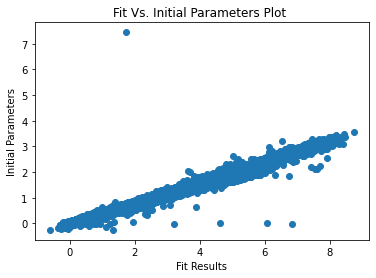

In [143]:
fit_results_1D = []
for fit_result in fit_results:
    fit_results_1D.append(fit_result.x)
    
fit_results_1D = np.concatenate(fit_results_1D)
    
all_columns_initial_params_1D = np.concatenate(all_columns_initial_params)

mplplot.scatter(fit_results_1D,all_columns_initial_params_1D)
mplplot.xlabel("Fit Results")
mplplot.ylabel("Initial Parameters")
mplplot.title("Fit Vs. Initial Parameters Plot ")

In [144]:
dfx2 = dfx.reset_index()
dfx2

,index,low_WL,high_WL,Direct_X,Direct_Y,RA,Dec
0,2,1190.617653,-552.410235,-350.219,2761.050,166.538658,-77.368153
1,62,1249.267653,-493.760235,-291.569,2214.600,166.534479,-77.377783
2,77,1253.754653,-489.273235,-287.082,738.874,166.535792,-77.403772
3,27,1374.203653,-368.824235,-166.633,2821.111,166.523950,-77.367183
4,33,1422.069653,-320.958235,-118.767,3081.354,166.519946,-77.362617
...,...,...,...,...,...,...,...
76,60,3937.981653,2194.953765,2397.145,1928.402,166.321112,-77.382772
77,78,3974.255653,2231.227765,2433.419,2151.594,166.318425,-77.378878
78,24,4022.226653,2279.198765,2481.390,642.758,166.312492,-77.405208
79,35,4044.791653,2301.763765,2503.955,2744.142,166.313175,-77.368531


### Testing fitted Spectra against original input

1334.88


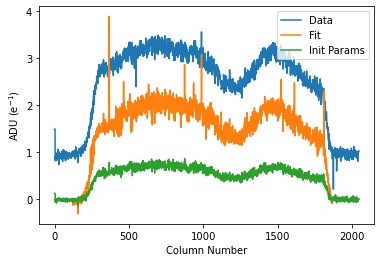

In [151]:
with apfits.open(imageFits) as test:
    data = test["SCI"].data
    print(dfx2.loc[8,"Direct_Y"])
    test_trace_input_data = np.sum(data[int(dfx2.loc[8,"Direct_Y"])-2 : int(dfx2.loc[8,"Direct_Y"])+2],axis=0)
    mplplot.plot(test_trace_input_data+1, label="Data")
    mplplot.plot(result[8],label='Fit')
    mplplot.plot(data[int(dfx2.Direct_Y[8])],label='Init Params')
    mplplot.xlabel("Column Number")
    mplplot.ylabel("ADU (e$^{-1}$)")
    mplplot.legend()
# See slight differences from data to fits as fit is from 25 rows where as data is sum of 4 rows across all columns
# Sharp peak at ~1400 unknown why this is happening (could be simulated CR hit)
# Added original errors and see more sudden unexpected peaks but fit still moved from initial params

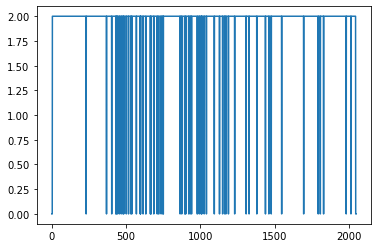

In [146]:
statuses = [result.status for result in fit_results]
cov = [result.hess_inv for result in fit_results]
# print(np.array(cov).flatten().shape)
# print(*statuses, sep='\n')
mplplot.plot(statuses)

### How many steps taken whilst fitting the initial params to the data

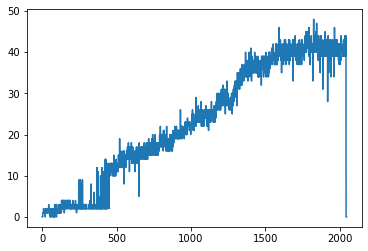

In [147]:
steps_taken = [result.nit for result in fit_results]
objective_func_value = [result.jac for result in fit_results]
# print(objective_func_value)
# The more traces there are, the more iterations required to fit each column
mplplot.plot(steps_taken)


(array([5591., 6006., 6152., 1578., 2514., 2141., 2232.,  795.,  477.,
         471.,  312.,  245.,  159.,  155.,  231.,  287.,  321.,  320.,
         412.,  344.,  300.,  116.,    8.]),
 array([0.        , 0.26086957, 0.52173913, 0.7826087 , 1.04347826,
        1.30434783, 1.56521739, 1.82608696, 2.08695652, 2.34782609,
        2.60869565, 2.86956522, 3.13043478, 3.39130435, 3.65217391,
        3.91304348, 4.17391304, 4.43478261, 4.69565217, 4.95652174,
        5.2173913 , 5.47826087, 5.73913043, 6.        ]),
 <BarContainer object of 23 artists>)

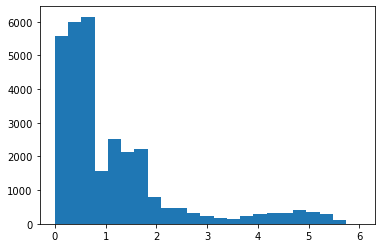

In [140]:
# List of Differences between intial parameters set for fit to the optimised results returned
init_to_opt = []
for (param, init) in zip(fit_results, all_columns_initial_params):
    for (sing_param, sing_init) in zip(param.x, init):
        init_to_opt.append(sing_param - sing_init)
mplplot.hist(init_to_opt, bins = np.linspace(0,6,24))
# Zero differences for columns with 0 traces in them

/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_frames/jw01309006001_01101_00001_nrcb5_rate_wcs.fits [2481.39   642.758] [-287.082  738.874]


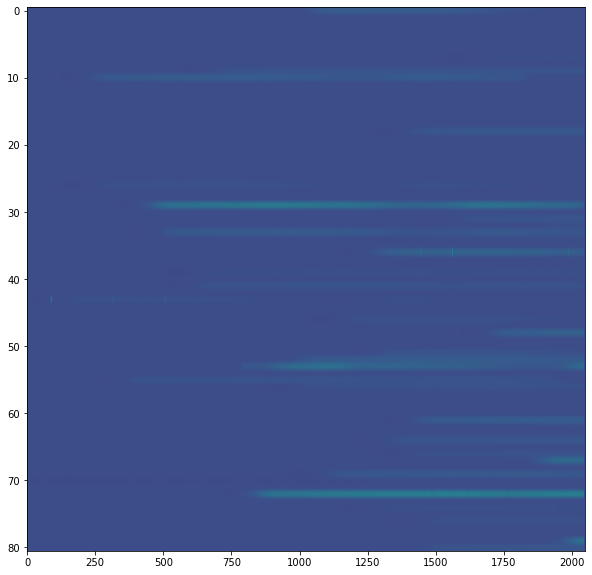

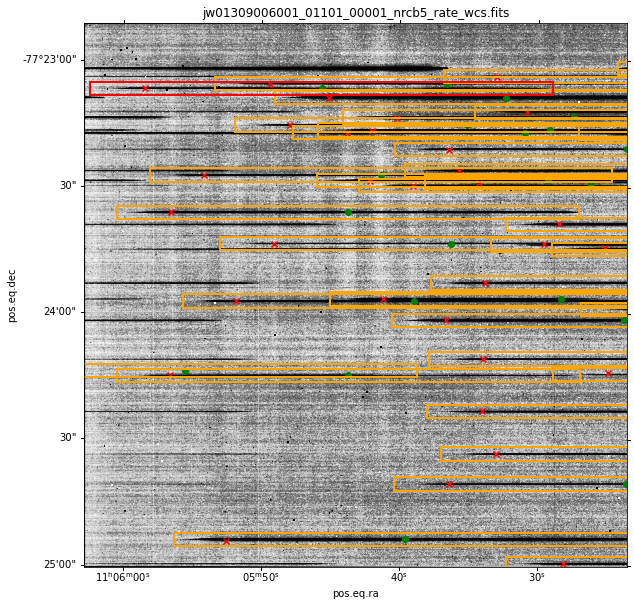

In [122]:
with apfits.open(imageFits) as test:
    mplplot.figure(figsize=(10,10))
    mplplot.imshow(result[dfx.sort_values("Direct_Y").index], aspect="auto")
    figure = mplplot.figure(figsize=(10, 10))
    ax = figure.add_subplot(1, 1, 1, projection=apwcs.WCS(test["SCI"].header))    
    ax.imshow(
        # SCI is the images from the simulation
        test["SCI"].data,
        norm=apvis.ImageNormalize(
            stretch=apvis.HistEqStretch(data=test["SCI"].data),
            interval=apvis.ZScaleInterval(),
        ),
        cmap="Greys",
    )
    # Set image limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    ax.scatter(
        sourceCoords.ra,
        sourceCoords.dec,
        marker="x",
        c="r",
        transform=ax.get_transform("world"),
    )
    ax.set_title(os.path.basename(imageFits))
        
#     directPixels = getSourcePixelsForImage(imageFits, frameListDir)
    print(imageFits, directPixels[24],directPixels[77] if len(directPixels) > 50 else "Short")
        
    # for loop to create trace boxes for each source within source list
    # HOW DO WE CHANGE FOR C DIRECTION?? NEED TO LOAD C DATA???
    # where is sourceId defined? Within imageFits???
    for sourceId, directPixel in enumerate(directPixels):
        traceBox = computeTraceBox(
            directPixel,
            module=os.path.basename(imageFits).split("_")[3][-2].upper(),
            direction="R",
            ec="red" if sourceId == 55 else "orange",
            #ec="orange",
            lw="2",
            fc="none",
        )
        ax.add_patch(traceBox)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

## NEED to adjust position of applying sensitivity model for each source 

In [123]:
SensFile = apfits.open(f"GRISM_NIRCAM/V2/NIRCam.F322W2.R.A.1st.sensitivity.fits")
print(repr(SensFile[1].header)) # Units check
SensTable = aptable.Table(SensFile[1].data)
SensData_WL = SensTable[0][:]
SensData_Sens = SensTable[1][:]
SensData_Er = SensData = SensTable[2][:]

trace = computeTrace(
        (dfx.Direct_X[0], dfx.Direct_Y[0]),
        # Fac must be set to 1 to match the number of pixels across trace
        fac=1,
        module=os.path.basename(imageFits).split("_")[3][-2].upper(),
        direction="R",
    )
print(trace)

# Set up the Spectral Response Function Curve to perform Flux calibration (from ADU to Flux)
SRFCurve = sp.interpolate.interp1d(SensData_WL,SensData_Sens,kind='cubic')

print("Length of the Astropy Table =", len(SensData_Sens))

test_SRF = SRFCurve(trace[2])
print("Length of the calculated trace (NON-BOX)=", len(trace[2]))
print("Length of the SRF with the calculated trace x values =", len(test_SRF))

#     extractedPanel.plot(table[0][:],table[1][:])
#     extractedPanel.plot(trace[2],test_SRF,ls='--')

# print("Length of the calculated trace (BOX)=", len(extracted))
#     data_SRF = SRFCurve(extracted)
#     print(len(extracted))
#     print(len(dataSRF))

calibratedFlux = result[::-1]/test_SRF
print(len(calibratedFlux))
    

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                 3541 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'WAVELENGTH'                                                          
TFORM1  = 'D       '                                                            
TTYPE2  = 'SENSITIVITY'                                                         
TFORM2  = 'D       '                                                            
TTYPE3  = 'ERROR   '        

ValueError: operands could not be broadcast together with shapes (81,2048) (1743,) 

<ipython-input-124-eee66feafa84>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  mplplot.figure()


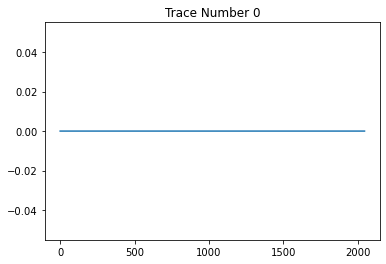

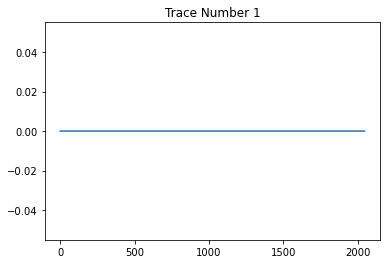

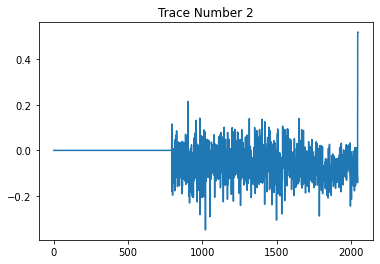

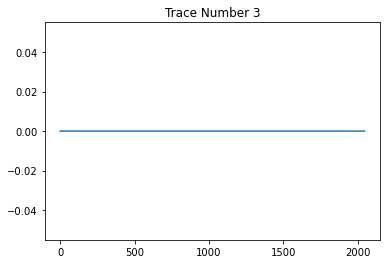

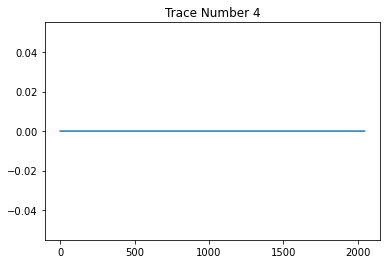

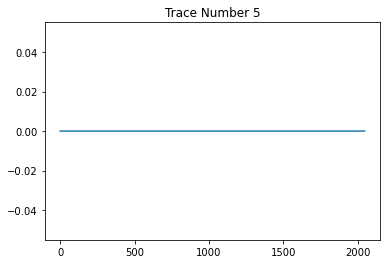

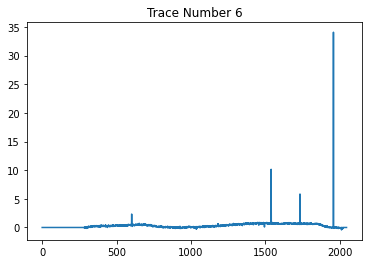

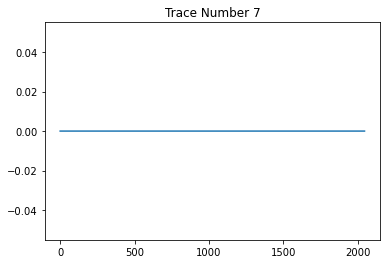

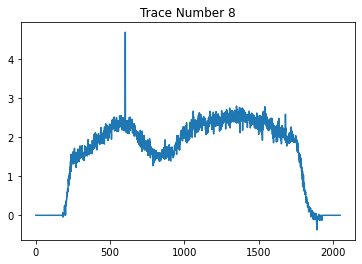

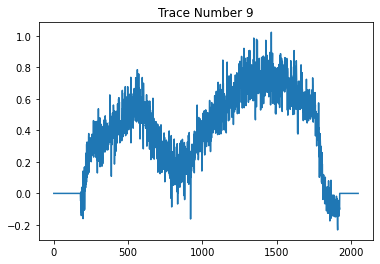

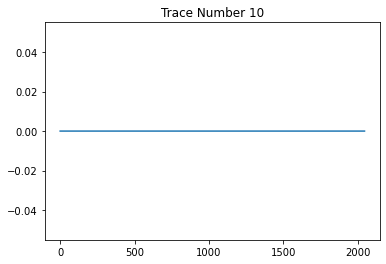

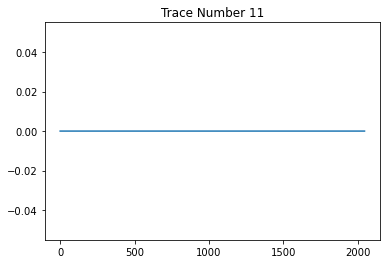

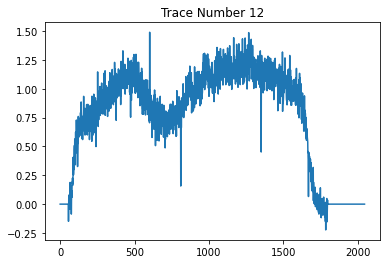

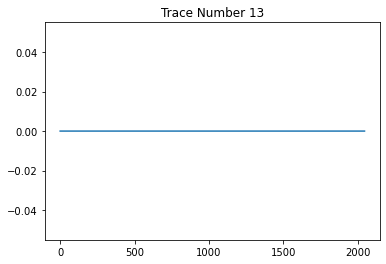

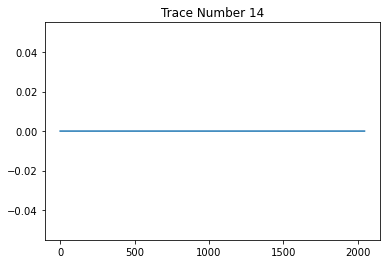

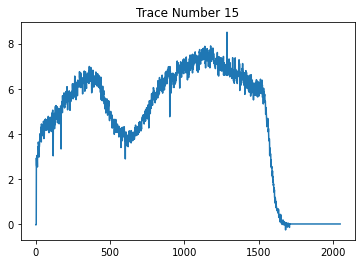

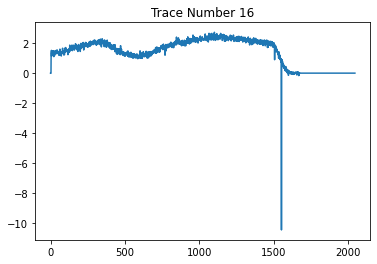

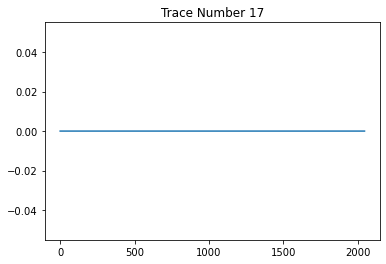

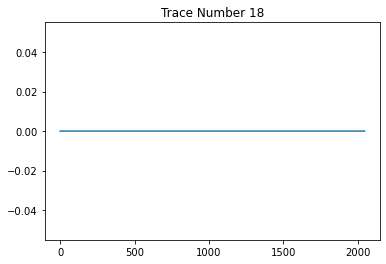

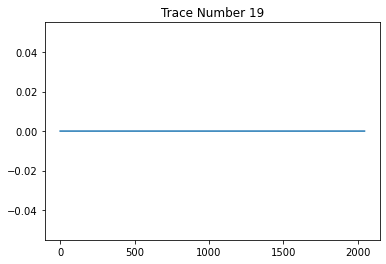

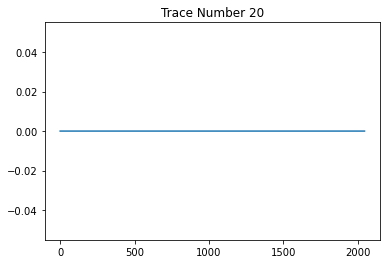

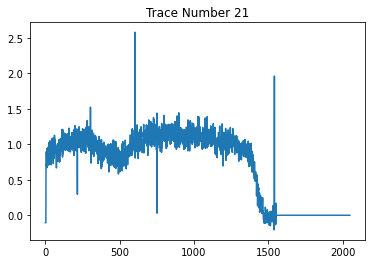

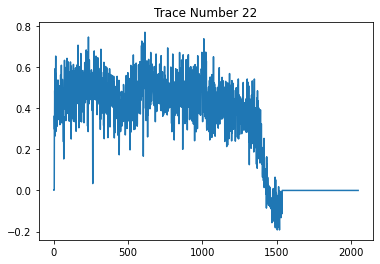

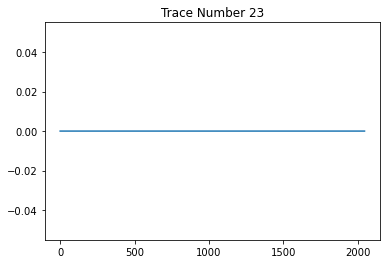

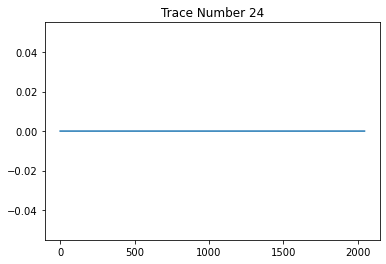

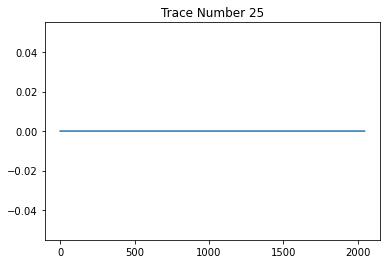

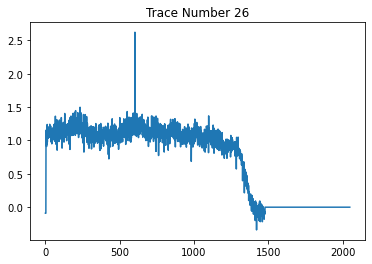

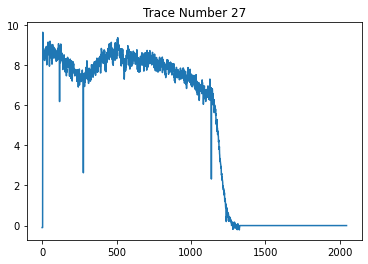

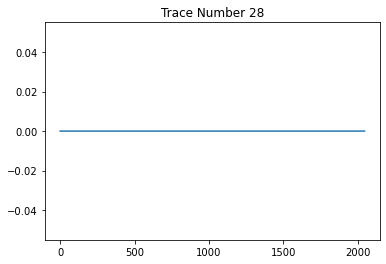

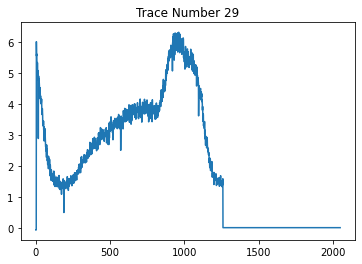

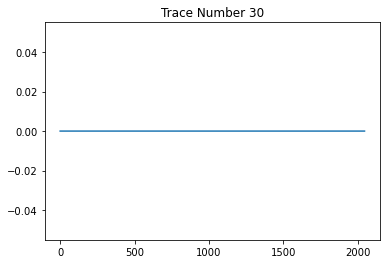

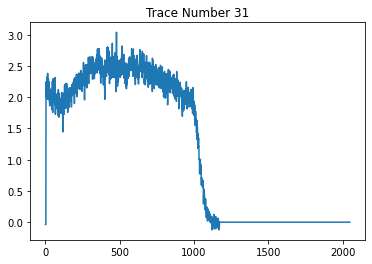

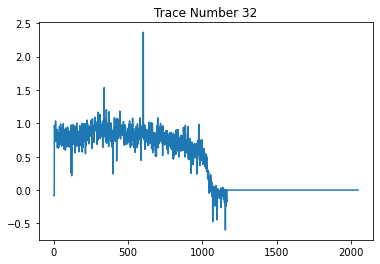

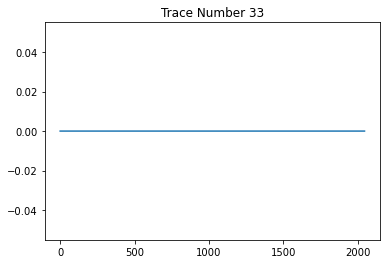

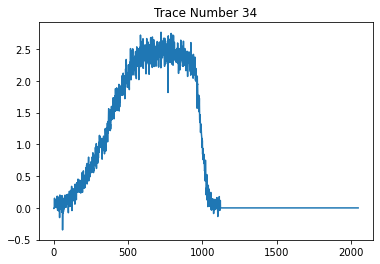

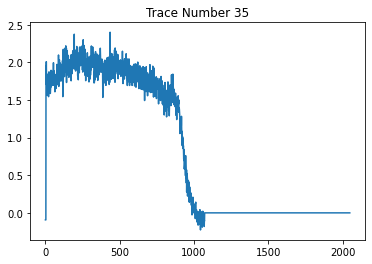

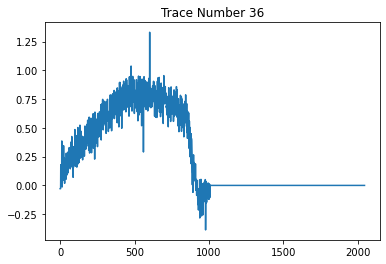

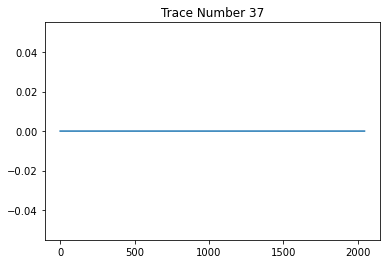

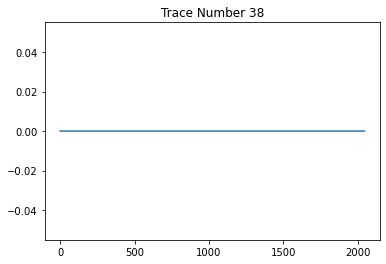

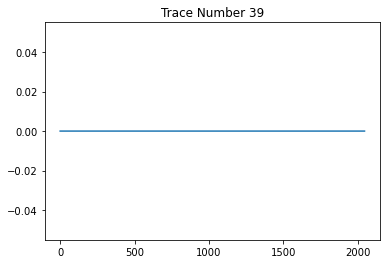

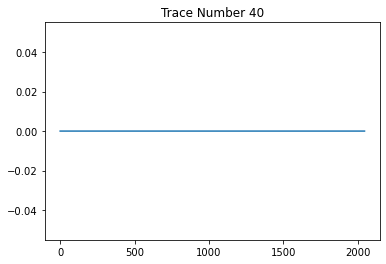

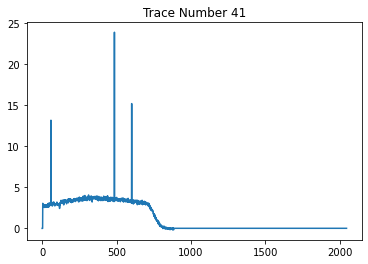

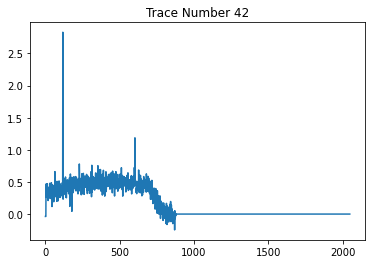

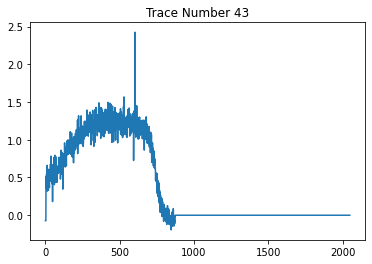

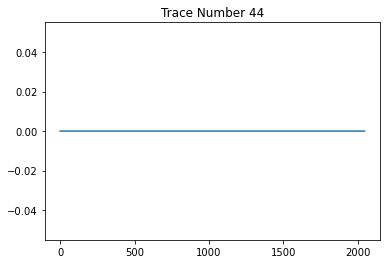

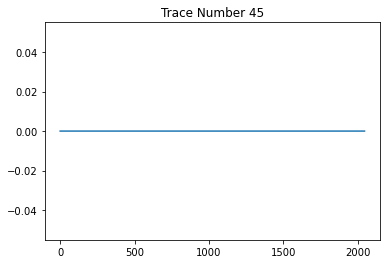

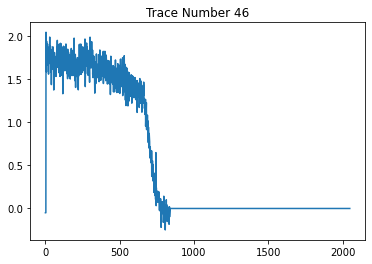

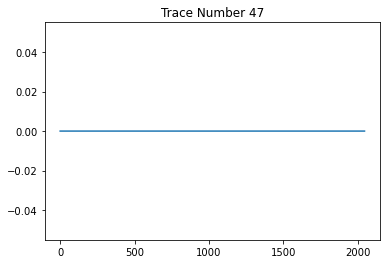

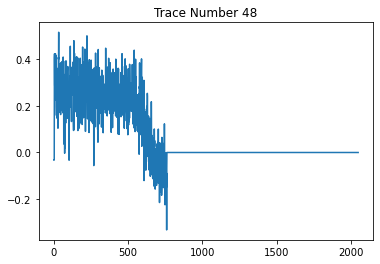

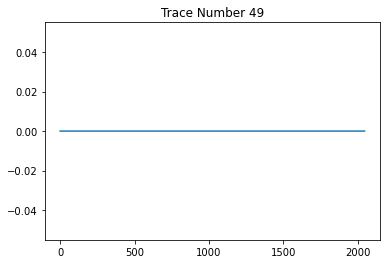

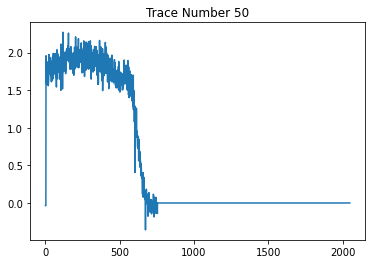

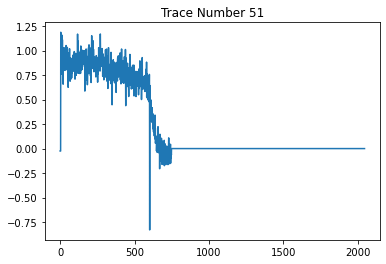

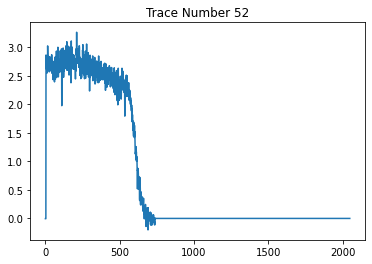

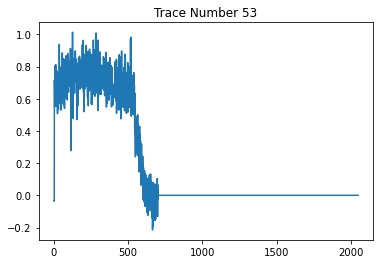

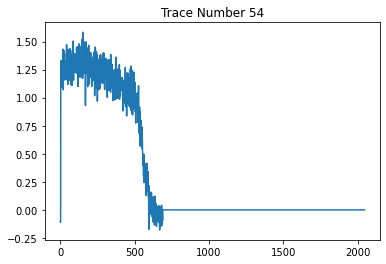

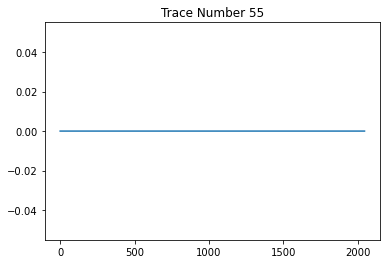

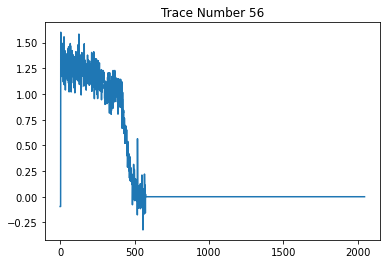

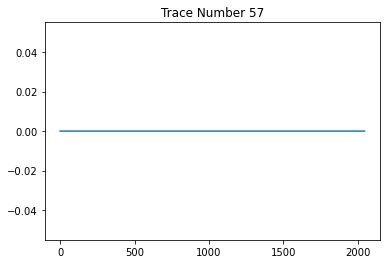

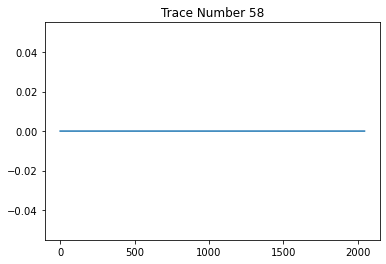

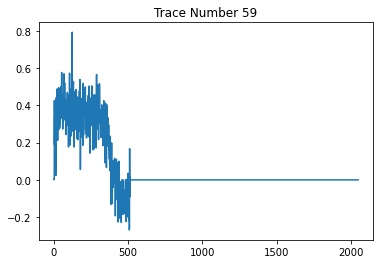

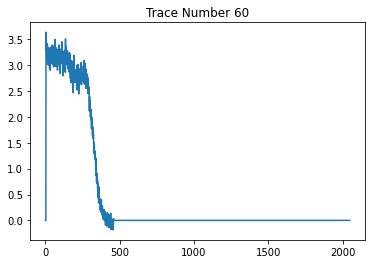

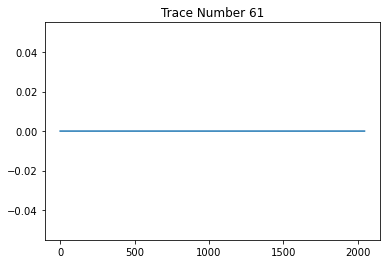

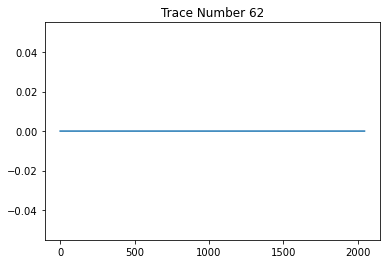

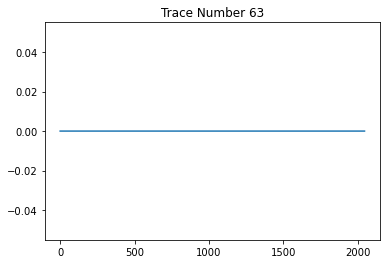

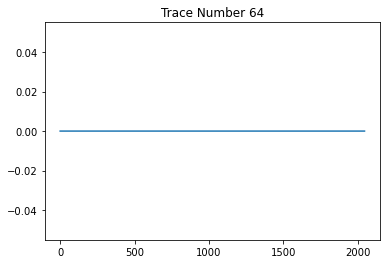

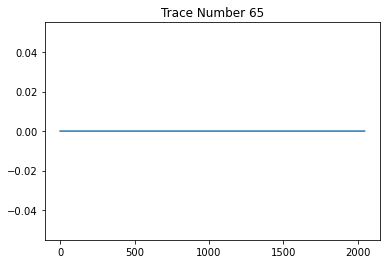

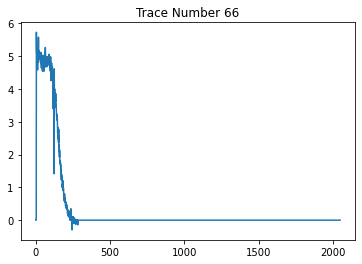

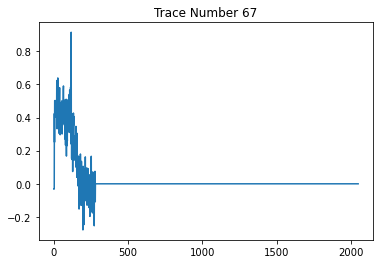

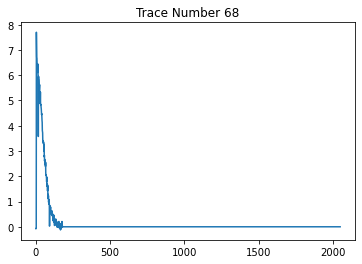

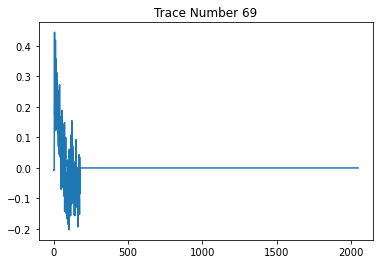

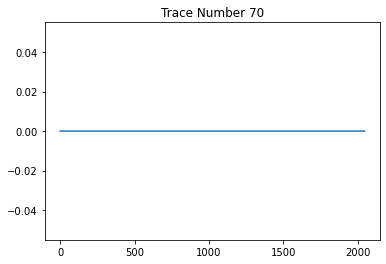

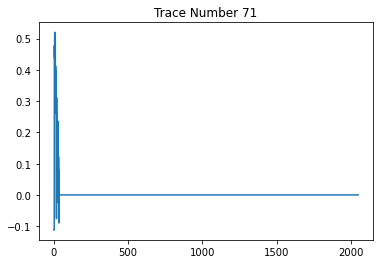

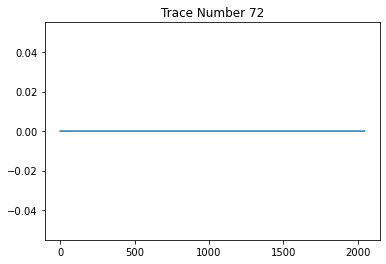

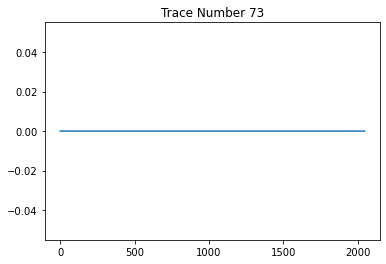

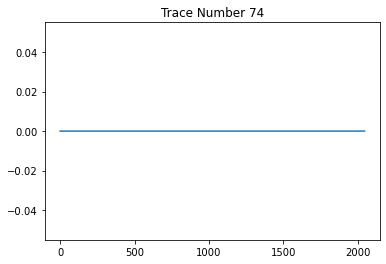

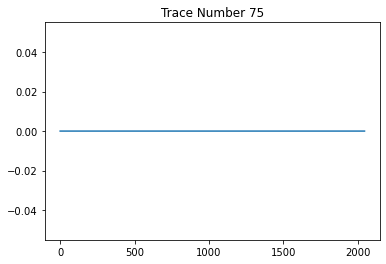

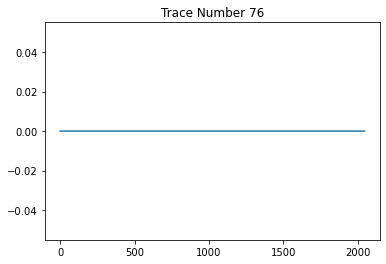

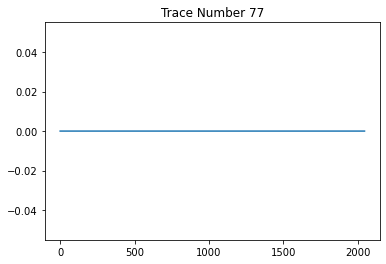

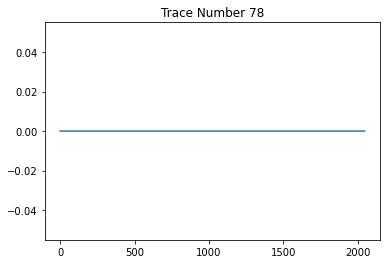

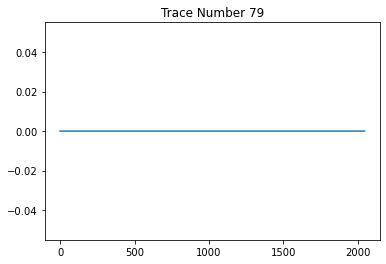

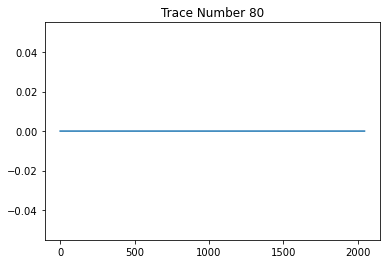

In [124]:
for position, sub_result in enumerate(result):
    mplplot.figure()
    mplplot.plot(sub_result[::-1])
    
    mplplot.title(f"Trace Number {position}")